# Gaussian Mixture State Projection: Concept

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we explore using Gaussian Mixutres (GM) as basis representations.
The GM is fitted using expectation maximization (EM).

As a proof of concept, we use randomly generated data. We test using this approach of univariate and bivariate tensors.

Formally, each state will be represented by a components vector $c$, where each element indicates a probability of membership to Gaussian distribution that is part of the Gaussian Mixture.

Thus, $\sum_{i}c_{i} = 1$, and $0 <= c_{i} <= 1$.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import mixture, model_selection

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

## Univeriate Case

We first explore projecting a single random variable, which the underlying process is a combination of two Normal distributions.

In [3]:
# generate a sample
X1 = np.random.normal(loc=20, scale=5, size=3000)
X2 = np.random.normal(loc=40, scale=5, size=7000)
X = np.hstack((X1, X2))

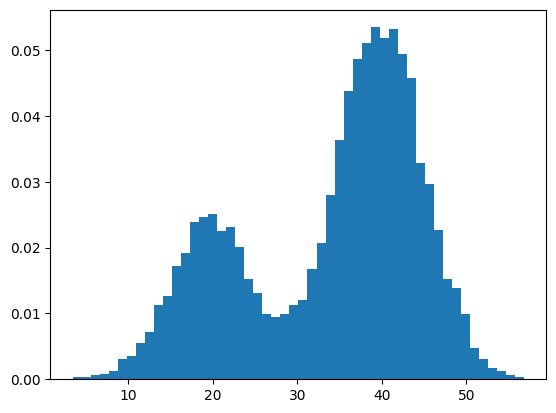

In [4]:
plt.hist(X, bins=50, density=True)
plt.show()

In [5]:
# reshape into a table with one column
X = X.reshape((len(X), 1))
# fit model
model = mixture.GaussianMixture(n_components=2, init_params="k-means++", max_iter=1000)
model.fit(X)

GaussianMixture(init_params='k-means++', max_iter=1000, n_components=2)

In [6]:
# predict latent values
yhat = model.predict(X)
# check latent value for first few points
print(yhat[:100])
# check latent value for last few points
print(yhat[-100:])

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
yhat_probs = model.predict_proba(X)
print(yhat_probs[:20])
print(yhat_probs[-20:])

[[2.09278628e-01 7.90721372e-01]
 [8.65039368e-01 1.34960632e-01]
 [9.43006098e-03 9.90569939e-01]
 [1.94177547e-03 9.98058225e-01]
 [2.10616285e-04 9.99789384e-01]
 [7.20474805e-02 9.27952519e-01]
 [3.43106509e-03 9.96568935e-01]
 [6.32053803e-03 9.93679462e-01]
 [9.21085007e-04 9.99078915e-01]
 [3.86316808e-04 9.99613683e-01]
 [5.45190614e-02 9.45480939e-01]
 [1.86200182e-02 9.81379982e-01]
 [5.86784342e-06 9.99994132e-01]
 [4.25549799e-01 5.74450201e-01]
 [3.24236445e-03 9.96757636e-01]
 [2.65501617e-02 9.73449838e-01]
 [7.53238341e-06 9.99992468e-01]
 [1.69703162e-01 8.30296838e-01]
 [1.75918377e-04 9.99824082e-01]
 [2.50585478e-05 9.99974941e-01]]
[[9.99749194e-01 2.50806445e-04]
 [9.99999897e-01 1.03198317e-07]
 [9.99993528e-01 6.47248961e-06]
 [9.99984861e-01 1.51392925e-05]
 [9.99029129e-01 9.70870801e-04]
 [9.98117677e-01 1.88232277e-03]
 [9.99963352e-01 3.66482156e-05]
 [9.99999936e-01 6.36041963e-08]
 [9.99669666e-01 3.30333818e-04]
 [9.99986486e-01 1.35137747e-05]
 [9.99999

In [8]:
# points in the left edge, "middle", right edge
model.predict_proba([[10], [20], [30], [40], [50]])

array([[1.69038412e-06, 9.99998310e-01],
       [1.76954923e-03, 9.98230451e-01],
       [8.34643577e-01, 1.65356423e-01],
       [9.99974375e-01, 2.56246699e-05],
       [9.99999999e-01, 1.22072082e-09]])

The probability memberships aling with the source distribution paramters: smaller values come from distribution `1` and the larger values from distribution `0`.

## Higher Dimensional Space

Next, we experiment with a `D=50` tensor into a smaller number of basis components.

In [9]:
def mv_normal(mu, eigenvalues):
    dim = len(mu)
    # ortho matrix
    ortho_matrix = stats.ortho_group.rvs(dim)
    # cov matrix; dim x dim
    cov = np.matmul(ortho_matrix, np.matmul(np.diag(eigenvalues), ortho_matrix.T))
    return stats.multivariate_normal(mu, cov)

In [10]:
def high_dim_data(dim: int, num_samples: int):
    mu = [np.random.rand()*np.random.randint(1, 100) for _ in range(dim)]
    eigenvalues = [np.random.rand()*np.random.randint(1, 1000) for _ in range(dim)]
    normal_dist = mv_normal(mu=mu, eigenvalues=eigenvalues)
    return normal_dist.rvs(size=num_samples)    

In [11]:
def high_dim_mixture(X, num_components: int):
    # generate a sample
    # fit model
    model = mixture.GaussianMixture(
        n_components=num_components, init_params="k-means++", max_iter=1000
    )
    model.fit(X)
    return model

In [12]:
d50_X = high_dim_data(dim=50, num_samples=100_000)

In [13]:
d50_model = high_dim_mixture(d50_X, num_components=10)

In [14]:
d50_yhat = d50_model.predict_proba(d50_X)

In [15]:
# check latent value for first few points
print(d50_yhat[:20])
# check latent value for last few points
print(d50_yhat[-20:])

[[6.16980428e-05 1.67979460e-03 7.29668386e-02 8.28312111e-03
  3.20055058e-05 2.65143940e-04 3.92505546e-02 2.39715165e-03
  1.82187271e-01 6.92876421e-01]
 [5.03456658e-05 1.86924382e-01 9.57330457e-02 9.18062473e-02
  3.01429033e-06 2.24971841e-02 5.91368284e-03 4.09243754e-01
  2.98285277e-02 1.57999816e-01]
 [9.92005162e-06 9.01277407e-02 3.33849865e-01 1.17769687e-01
  7.25531830e-03 4.52471177e-04 3.73432066e-01 4.03605912e-04
  5.04822210e-03 7.16511031e-02]
 [7.52141023e-09 1.14003250e-02 3.06365892e-02 4.01697655e-02
  6.64654506e-03 4.69433776e-03 9.03432795e-01 1.41293858e-04
  7.87302182e-05 2.79961099e-03]
 [4.49235060e-04 3.41826780e-02 1.09496140e-01 2.38101333e-01
  3.81485395e-01 7.27300415e-02 1.01075600e-02 3.28730547e-03
  9.70325493e-02 5.31277628e-02]
 [3.02805896e-02 1.07283959e-03 4.53538181e-01 4.75144943e-02
  1.67790778e-01 4.60323543e-04 3.46470243e-02 3.90132088e-04
  1.41146885e-03 2.62894169e-01]
 [6.60118313e-07 1.22539182e-04 9.55067747e-02 4.21487824e

In [16]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [17]:
param_grid = {
    "n_components": (5, 10, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = model_selection.GridSearchCV(
    mixture.GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(d50_X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': (5, 10, 15)},
             scoring=<function gmm_bic_score at 0x7f4946833240>)

In [18]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score")

,Number of components,Type of covariance,BIC score
3,5,tied,8.002789e+06
4,10,tied,8.005399e+06
5,15,tied,8.007990e+06
9,5,full,8.054576e+06
10,10,full,8.122752e+06
11,15,full,8.191606e+06
8,15,diag,8.336522e+06
2,15,spherical,8.336740e+06
7,10,diag,8.342926e+06
1,10,spherical,8.346135e+06


/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warnin

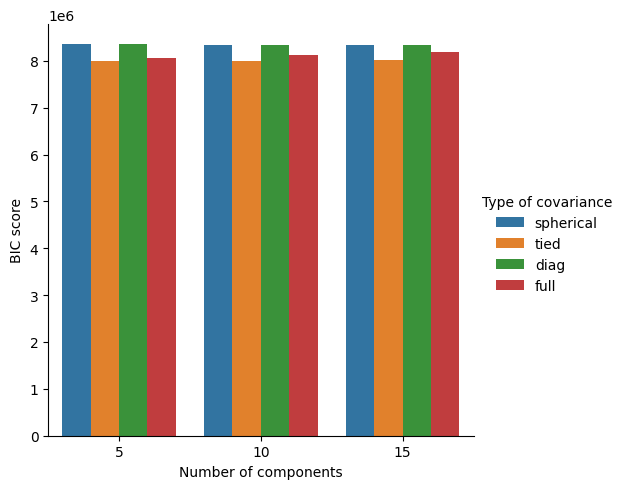

In [19]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

As a measure of goodness, scikit-learn's implementation of GM with EM uses [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) - which indicates overfit as a result of complexity. The lower the value the better.

With this approach, we can test different parameters of the Gaussian Mixture on each environment.
The plan is then to generate sample data from an environment, and fit a Gaussian Mixture using hyper-parameter search to find the best fit.